# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Opencv predefined  Functions that i have used for Lane Detection Pipeline

`cv2.cvtColor()`To convert from RGB to Greysacle
`cv2.GaussianBlur`To apply gussian Blur to smoothen image and remove noise 
`cv2.line()`To draw lines on detected lines after applying hough transform
`cv2.HoughLinesP`For applying hough transform to detect lines 
`cv2.canny()`For edge detection
`cv2.inRange()`For color selection  
`cv2.fillPoly()`For regions selection  
`cv2.line()`To draw lines on an image given endpoints  
`cv2.addWeighted()`To coadd / overlay two images
`cv2.cvtColor()`To grayscale or change color
`cv2.imwrite()`To output images to file  
`cv2.bitwise_and()`To apply a mask to an image



## Code Starts from here

### Importing Pacadges

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

### Defining Varaibles and Parameters 

In [69]:
#ROI Paramters 
Quad_bottom_width = 0.85 
Quad_top_width = 0.07 
Quad_height = 0.4 

#Hough Transform Parameters
rho = 2                  # distance resolution in pixels of the Hough grid
theta = np.pi/180        # angular resolution in radians of the Hough grid
threshold = 350          # minimum number of votes (intersections in Hough grid cell)
min_line_length = 120    # minimum number of pixels making up a line
max_line_gap = 90        # maximum gap in pixels between connectable line segments

### Defining my functions in the pipeline and applying predefined opencv functions which are mentioned up for lane detection 


In [70]:
#-------------------_ROI_Function--------------------------------------
#......................................................................

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2] # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [71]:
#-------------------__Convert_To_Grey_Scale_Function------------------------------
#.................................................................................

def grayscale(img):
    #img=cv2.imread(img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


In [72]:
#-------------------_Hough_Transform_Function-------------------------------------
#.................................................................................
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

#-------------------_Drawing_Lines_Function--------------------------------------
#................................................................................
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [73]:
#-------------------__Canny_To_detect_edges_Function------------------------------
#.................................................................................

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#-------------------__ Gaussian_blur_Function------------------------------------
#.................................................................................

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [74]:
#-------------------__ Weighted_img_Function--------------------------------------
#.................................................................................

def weighted_img(img, initial_img,a=0.8, b=1., s=0.):
    return cv2.addWeighted(initial_img, a, img, b, s)

In [75]:
#-------------------__ Filter_colors_Function------------------------------------
#.................................................................................

def filter_colors(image):
    white_threshold = 200 #130
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)
    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)
    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)
    #plt.imshow(image2)
    return image2 

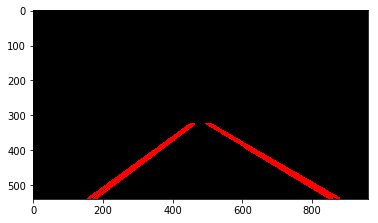

In [82]:
#######################################################################################################################
## -------------------------------------------Code Start From here----------------------------------------------------#
#######################################################################################################################


## Reading Images & Passing them to functions to start processing 
#reading in an image
#ximg = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#ximg = mpimg.imread('test_images/solidYellowLeft.jpg')
ximg = mpimg.imread('test_images/solidYellowCurve2.jpg')
#ximg = mpimg.imread('test_images/solidYellowCurve.jpg')
#ximg = mpimg.imread('test_images/solidWhiteRight.jpg')
#plt.imshow(ximg) 

img = filter_colors(ximg)
img = grayscale(ximg)
img = canny(img,50,150)
#plt.imshow(img)
img = gaussian_blur(img,5)
imshape = img.shape # ROI polygon mask
vertices = np.array([[\
        ((imshape[1] * (1 - Quad_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - Quad_top_width)) // 2, imshape[0] - imshape[0] * Quad_height),\
        (imshape[1] - (imshape[1] * (1 - Quad_top_width)) // 2, imshape[0] - imshape[0] * Quad_height),\
        (imshape[1] - (imshape[1] * (1 - Quad_bottom_width)) // 2, imshape[0])]]\
        ,dtype=np.int32)
img = region_of_interest(img , vertices)
#plt.imshow(img)
img = hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap)
#plt.imshow(img)
initial_image = ximg.astype('uint8')
#plt.imshow(img)
img = weighted_img(img,initial_image)




## Display Image Result 


True

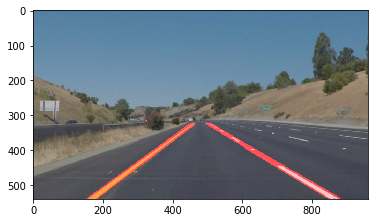

In [77]:
#Note : Every Image needs tunning to achieve good results 
plt.imshow(img) #Show Image Result
cv2.imwrite('my_test_Images_&_videos_output/solidYellowCurve2_Result.jpeg',img)#Save Image 

## Process Pipeline on a video 



In [78]:
# Import everything needed to edit/save/watch video clips
#from moviepy.editor import VideoFileClip
#from IPython.display import HTML

#clip = VideoFileClip('test_videos/solidWhiteRight.mp4')
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

#white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [79]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

NameError: name 'VideoFileClip' is not defined

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))